In [2]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [3]:
from utils import *

In [4]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.metrics import SpecificityAtSensitivity
from keras.utils import plot_model
from matplotlib import pyplot

In [5]:
#Load the dataset where features have null values
state_cols_1 = ['ER', 'series_id_0', 'series_id_1', 'series_id_2', 'series_id_3', 'gpl_0', 'gpl_1', 'gpl_2', 'pam_coincide_0', 'pam_coincide_1', 'pam_coincide_2', 'pam_coincide_3', 'pam_coincide_4', 'radiotherapyClass_0', 'radiotherapyClass_1', 'p5_0', 'p5_1', 'p5_2', 'p5_3', 'p5_4']
ge_state_nn = pd.read_csv("datasets/ge_state_outcome_tamoxifen_v3.csv",
            index_col="patient_ID")
ge_df = ge_state_nn[ge_state_nn.columns.difference(state_cols_1)]
ge_df

,A4GALT,AAAS,AACS,AADAC,AAK1,AAMP,AANAT,AARS,AARSD1,AASDHPPT,...,ZP2,ZPBP,ZSCAN2,ZW10,ZWINT,ZXDC,ZYX,ZZEF1,ZZZ3,posOutcome
patient_ID,,,,,,,,,,,,,,,,,,,,,
249296,4.664051,5.331150,7.126872,4.296764,4.716382,6.412946,4.153878,8.731168,5.068564,6.777534,...,3.458515,2.366422,3.493543,4.502112,7.000903,5.250279,8.595672,4.591821,5.901994,0
249524,4.218617,5.451971,7.483900,4.064093,5.284597,5.947109,3.170668,8.479083,5.785558,7.896858,...,2.912184,2.491172,3.011831,5.192674,5.999150,4.597011,8.041897,4.905542,8.131689,1
249527,4.481819,6.174727,8.191183,2.564228,4.500322,6.919824,3.452601,8.982715,5.571973,7.888242,...,2.954979,2.295199,3.118038,5.181799,5.665467,4.806405,8.775220,4.301683,5.929492,0
249529,4.673300,5.642042,7.362706,2.967516,4.010832,6.559165,3.886112,8.801044,5.849917,7.330794,...,3.324211,2.267870,3.371561,4.666363,6.405824,5.002028,8.645329,4.421538,5.530777,0
249530,4.751811,6.319986,8.600319,2.798135,4.662354,7.380506,3.602703,9.012348,5.554337,8.226949,...,2.572928,2.327541,3.318911,5.326518,5.581286,4.960007,8.778932,4.873731,5.715205,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,3.426381,5.768145,7.905766,3.240755,5.892294,7.772861,3.202970,7.107005,5.831064,6.319643,...,3.144302,3.158701,3.521218,4.108018,7.274987,5.773784,6.179846,5.780236,6.254059,1
305261,3.420373,5.345412,8.006344,3.240755,6.770604,7.135544,3.202970,7.260247,5.583641,6.552227,...,3.144302,3.158701,3.521218,3.830114,8.424351,5.322723,6.510751,5.732561,6.278364,1
305262,3.426381,5.335712,7.368003,3.240755,5.430695,6.166192,3.202970,5.489873,4.955997,7.501677,...,3.144302,3.158701,3.521218,3.595001,9.804475,4.587512,3.799424,6.155523,7.120667,1


In [6]:
X, y = ge_df.drop(["posOutcome"], axis=1), ge_df["posOutcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

In [7]:
n_inputs = X_train.shape[1]
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
#encoder
visible = Input(shape=(n_inputs, ))
#encoder l-1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

#encoder l-2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [9]:
#bottleneck
n_feats = 100
bottleneck = Dense(n_feats)(e)

In [10]:
#decoder l-1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#decoder l-2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [11]:
#output layer
output = Dense(n_inputs, activation="linear")(d)
#encoder model
model = Model(inputs=visible, outputs=output)
model.compile(optimizer="adam", loss="mse")

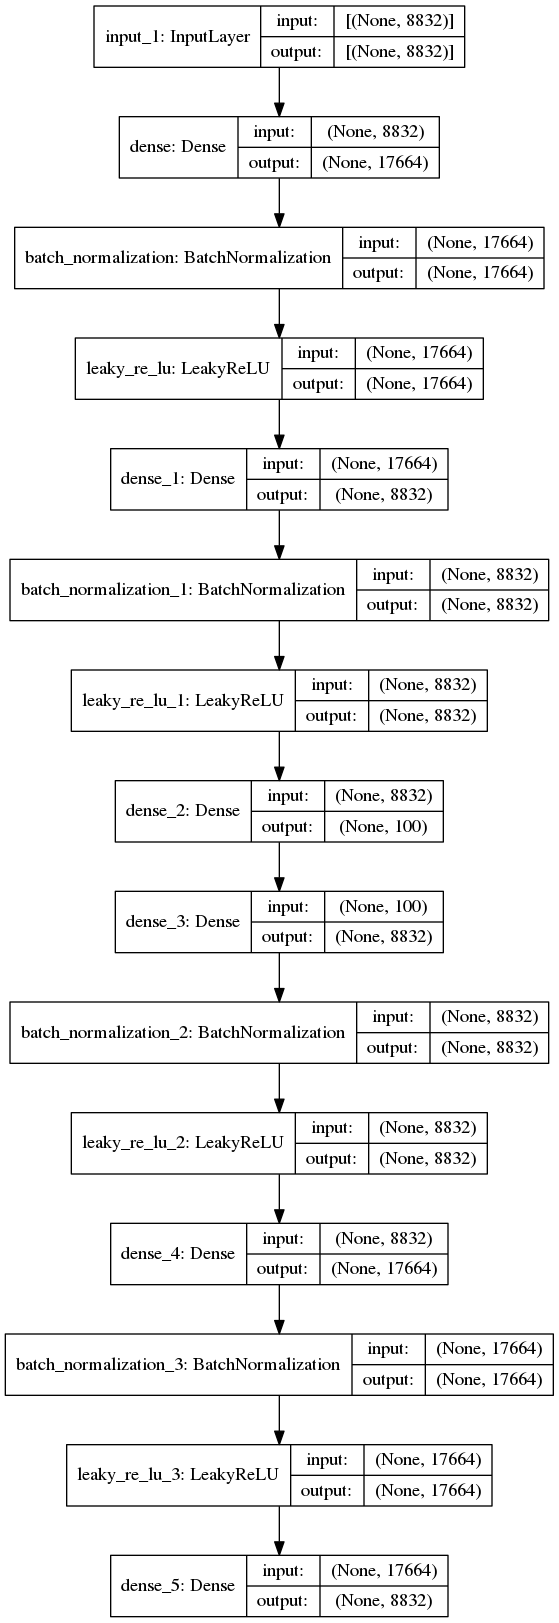

In [12]:
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)


In [8]:
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter

X_train_smote, y_train_smote = KMeansSMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smote).items()))

[(0, 329), (1, 329)]


In [45]:

# fit the autoencoder model to reconstruct input
history = model.fit(X_train_smote, X_train_smote, epochs=50, batch_size=32,
            verbose=2, validation_data=(X_test, X_test))


ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.

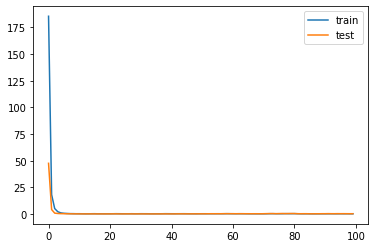

In [18]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('datasets/encoder.h5')

In [20]:
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)
print(f"Train shape: ${X_train_enc.shape}\n Test shape: ${X_test_enc.shape}")



Train shape: $(449, 100)
 Test shape: $(193, 100)


In [21]:
params_dl_v1, clf_dl_v1, cv_scores_dl_v1, test_scores_dl_v1 = evaluate_ge((X_train_enc, X_test_enc, y_train, y_test), split=False)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[20:52:18] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:52:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 25.15 seconds.
Best Score: 58.788%
{'subsample': 1.0, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 2, 'colsample_bytree': 1.0}
[20:54:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   20.3s finished


In [22]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(X_train_enc, y_train)
y_pred = log_clf.predict(X_test_enc)
acc = balanced_accuracy_score(y_test, y_pred)
print(acc)

0.5454984810825739


In [9]:
#Using a stacked denoising autoencoder(SDAE)
from sdae import StackedDenoisingAE

sdae_model = StackedDenoisingAE(n_layers=3, n_hid=[100], dropout = [0.2], nb_epoch=20)

model, (dense_train, dense_val, dense_test), recon_mse = sdae_model.get_pretrained_sda(X_train_smote, X_test, X_test, dir_out="datasets/")


Training layer 0
Epoch 1/20
656/658 [============================>.] - ETA: 0s - loss: 0.0288  

KeyboardInterrupt: 

In [ ]:
sdae_model

In [43]:
X_test_enc_v2 = sdae_model.transform(X_test)

In [44]:
params_dl_v2, clf_dl_v2, cv_scores_dl_v2, test_scores_dl_v2 = evaluate_ge((X_train_enc_v2, X_test_enc_v2, y_train_smote, y_test), split=False)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:16:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 2.96 seconds.
Best Score: 50.000%
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 1.0}
[21:16:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.8s finished


In [111]:
X_train_enc_v2.shape

(449, 100)